In [14]:
import numpy as np
import time
import glob
from datetime import datetime 
from darts.dataprocessing import Pipeline
import matplotlib.pyplot as plt
import shutil
import warnings
warnings.filterwarnings("ignore")
import logging
import pandas as pd

from tqdm import tqdm

# model
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist
from darts.utils.missing_values import fill_missing_values
import torch
from darts.models import RNNModel
from darts.metrics import mape # we do not use mape, this is a problem using backtest!
from darts.metrics import rmse, mse

# mlflow
!pip install mlflow --q
import mlflow

In [2]:
# data import and preprocessing
csv_files = glob.glob('/Users/dicod/semester_projects_02/Data/*.csv')
df = pd.DataFrame()

for file in csv_files:
    temp_df = pd.read_csv(file)
    df = pd.concat([df, temp_df], ignore_index=True)

df = df[['MTU (CET/CEST)','Day-ahead Price [EUR/MWh]']]
df = df.rename(columns={'MTU (CET/CEST)': 'date', 'Day-ahead Price [EUR/MWh]': 'Price'})

df['date'] = df['date'].apply(lambda x: x[0:16])
df['Price'].fillna(df['Price'].interpolate(), inplace=True)
df_no_duplicates = df.drop_duplicates(subset='date')
df_no_duplicates.to_csv('df_clean.csv')

In [3]:
df = pd.read_csv('df_clean.csv')

In [4]:
time_series = TimeSeries.from_dataframe(df, time_col='date', value_cols = 'Price', fill_missing_dates=True, freq=None)
ts = time_series

In [5]:
# model build
# Create training and validation sets:
train, test = ts.split_after(pd.Timestamp("01.01.2022 01:00"))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
test_transformed = transformer.transform(test)
series_transformed = transformer.transform(ts)

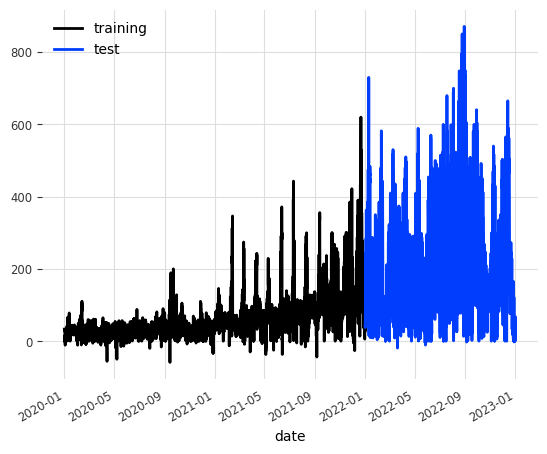

In [6]:
# dart recommendation, but I think we will use random methold.
train.plot(label="training")
test.plot(label="test")

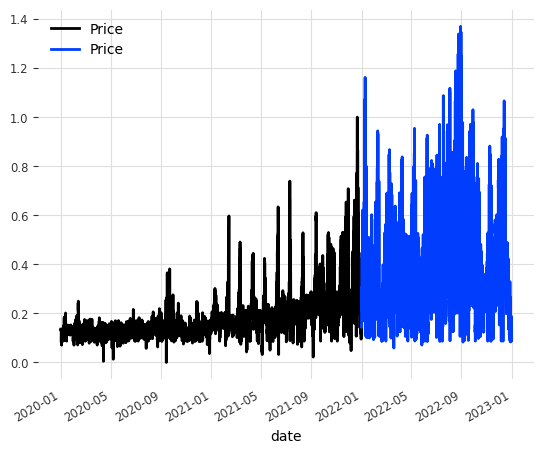

In [15]:
train_transformed.plot()
test_transformed.plot()

# Covariates Effect

note that: https://unit8co.github.io/darts/examples/04-RNN-examples.html#Recurrent-Models

why we used scaler:


In [16]:
# create day and time covariate series_basic one (I think our data is important day and hour relationship.)

hour_series = datetime_attribute_timeseries(
    pd.date_range(start=ts.start_time(), freq=ts.freq_str, periods=26304),
    attribute="hour",
    one_hot=False)
day_series = datetime_attribute_timeseries(
    pd.date_range(start=ts.start_time(), freq=ts.freq_str, periods=26304),
    attribute="day",
    one_hot=False)
month_series = datetime_attribute_timeseries(
    pd.date_range(start=ts.start_time(), freq=ts.freq_str, periods=26304),
    attribute="month",
    one_hot=False)
year_series = datetime_attribute_timeseries(
    pd.date_range(start=ts.start_time(), freq=ts.freq_str, periods=26304),
    attribute="year",
    one_hot=False)
weekday_series = datetime_attribute_timeseries(
    pd.date_range(start=ts.start_time(), freq=ts.freq_str, periods=26304),
    attribute="dayofweek",
    one_hot=False)
weekofyear_series = datetime_attribute_timeseries(
    pd.date_range(start=ts.start_time(), freq=ts.freq_str, periods=26304),
    attribute="weekofyear",
    one_hot=False)

In [17]:
# series_transform
hour_trasform = Scaler().fit_transform(hour_series)
day_transform = Scaler().fit_transform(day_series)
month_transform = Scaler().fit_transform(month_series)
year_transform = Scaler().fit_transform(year_series)
weekday_transform = Scaler().fit_transform(weekday_series)
weekofyear_transform = Scaler().fit_transform(weekofyear_series)

In [18]:
# we make 3 kinds of covariates : day and hour, dayofweek and dayofyear, all

cov_day_hour = day_transform.stack(hour_series)
cov_dayofweek_dayofyear = weekday_transform.stack(weekofyear_transform)
cov_all = hour_trasform.stack(day_transform).stack(month_transform).stack(year_transform).stack(weekday_transform).stack(weekofyear_transform)

In [24]:
cov_all

<TimeSeries (DataArray) (time: 26304, component: 6, sample: 1)>
array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.33333333],
        [0.        ]],

       [[0.04347826],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.33333333],
        [0.        ]],

       [[0.08695652],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.33333333],
        [0.        ]],
...
       [[0.91304348],
        [1.        ],
        [1.        ],
        [1.        ],
        [0.83333333],
        [0.98076923]],

       [[0.95652174],
        [1.        ],
        [1.        ],
        [1.        ],
        [0.83333333],
        [0.98076923]],

       [[1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [0.83333333],
        [0.98076923]]])
Coordinates:
  * time       (time) datetime64[ns] 2020-01-01 ... 2022-12-31T23:00:00
  * component  (component) object 'hour' 'day' ... 'dayofweek' 'weekofyear'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

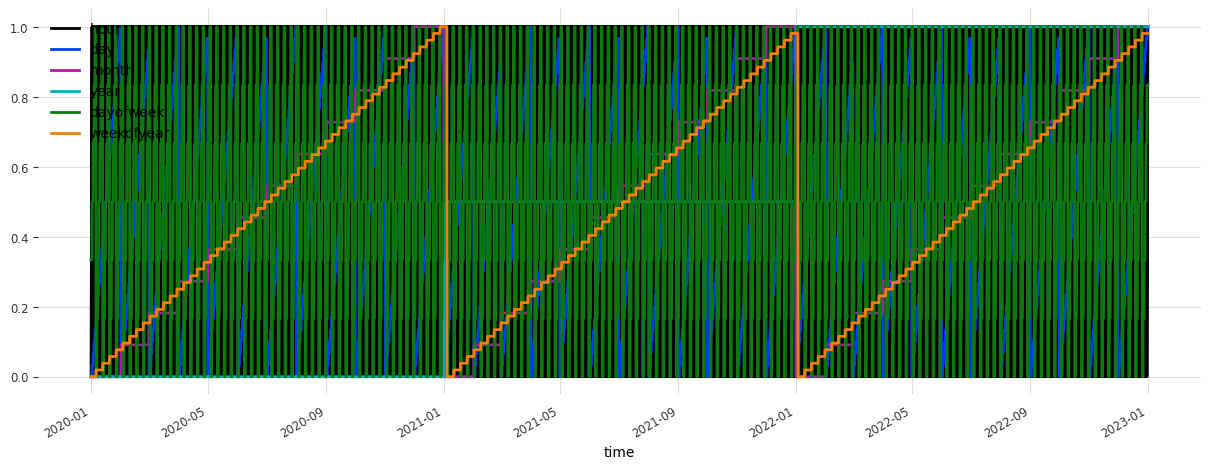

In [19]:
plt.figure(figsize=(15,5))
cov_all.plot()

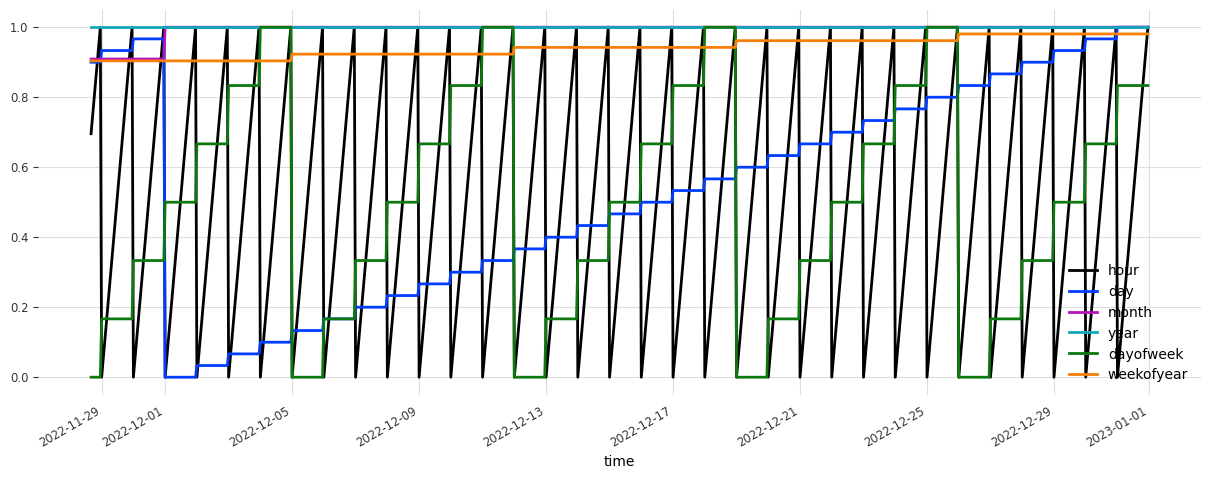

In [22]:
plt.figure(figsize=(15,5))
cov_all[-800:].plot()

In [26]:
scaled_day_series = Scaler().fit_transform(day_series)
hour_series = datetime_attribute_timeseries(scaled_day_series, attribute="hour", one_hot=True)

In [28]:
covariates_day_hour = scaled_day_series.stack(hour_series)

cov_train, cov_test = covariates_day_hour.split_after(pd.Timestamp('01.01.2022 01:00'))

In [30]:
year_series = datetime_attribute_timeseries(
    pd.date_range(start=ts.start_time(), freq=ts.freq_str, periods=26304),
    attribute="day",
    one_hot=False)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(
    year_series, attribute="month", one_hot=True
)
covariates_ym = year_series.stack(month_series)
cov_train, cov_val = covariates_ym.split_after(pd.Timestamp('01.01.2022 01:00'))

In [ ]:
# Start an MLflow run_with cov_all
from sklearn.metrics import r2_score

mlflow.autolog()

mlflow.set_experiment('EL_Price_experiments')


# Load data
data = pd.read_csv('df_clean.csv')
time_series = TimeSeries.from_dataframe(df, time_col='date', value_cols = 'Price', fill_missing_dates=True, freq=None)

# Split data and scaler
train, test = ts.split_after(pd.Timestamp("01.01.2022 01:00"))
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
test_transformed = transformer.transform(test)
series_transformed = transformer.transform(ts)

with mlflow.start_run(run_name="run_6", nested=True):
    my_model = RNNModel(
    model="LSTM",
    hidden_dim=20, #
    dropout=0,
    batch_size=24, 
    n_epochs=100, # try it: 30, 50, 100
    optimizer_kwargs={"lr": 1e-3},
    model_name="ELPrice_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=72,
    force_reset=True,
    save_checkpoints=True,
)

# Train a RNN model
    my_model.fit(
    train_transformed,
    future_covariates=cov_all,
    val_series=test_transformed,
    val_future_covariates=cov_all,
    verbose=False,
)
    
    def eval_model(model):
        pred_series = model.predict(n=8750, future_covariates=cov_all)
        plt.figure(figsize=(8, 5))
        series_transformed.plot(label="actual")
        pred_series.plot(label="forecast")
        r2 = r2_score(test_transformed, pred_series)
        plt.title("R-squared: {:.2f}".format(r2))
        plt.legend()


    eval_model(my_model)
    


2023/05/15 21:56:21 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/05/15 21:56:24 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/05/15 21:56:24 INFO mlflow.tracking.fluent: Autologging successfully enabled for pytorch_lightning.
2023/05/15 21:56:24 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/05/15 21:56:24 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# Start an MLflow with cov_dayofweek_dayofyear

mlflow.autolog()

mlflow.set_experiment('EL_Price_experiments')


# Load data
data = pd.read_csv('df_clean.csv')
time_series = TimeSeries.from_dataframe(df, time_col='date', value_cols = 'Price', fill_missing_dates=True, freq=None)

# Split data and scaler
train, test = ts.split_after(pd.Timestamp("01.01.2022 01:00"))
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
test_transformed = transformer.transform(test)
series_transformed = transformer.transform(ts)

with mlflow.start_run(run_name="run_7", nested=True):
    my_model = RNNModel(
    model="LSTM",
    hidden_dim=10, #
    dropout=0,
    batch_size=24, 
    n_epochs=100, # try it: 30, 50, 100
    optimizer_kwargs={"lr": 1e-3},
    model_name="ELPrice_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=72,
    force_reset=True,
    save_checkpoints=True,
)

# Train a RNN model
    my_model.fit(
    train_transformed,
    future_covariates=cov_all,
    val_series=test_transformed,
    val_future_covariates=cov_all,
    verbose=False,
)
    
    def eval_model(model):
        pred_series = model.predict(n=8700, future_covariates=cov_all)
        plt.figure(figsize=(8, 5))
        series_transformed.plot(label="actual")
        pred_series.plot(label="forecast")
        plt.title("MAPE: {:.2f}%".format(mape(pred_series, test_transformed)))
        plt.legend()


    eval_model(my_model)

In [ ]:
# Start an MLflow run_with cov_all

mlflow.autolog()

mlflow.set_experiment('EL_Price_experiments')


# Load data
data = pd.read_csv('df_clean.csv')
time_series = TimeSeries.from_dataframe(df, time_col='date', value_cols = 'Price', fill_missing_dates=True, freq=None)

# Split data and scaler
train, test = ts.split_after(pd.Timestamp("01.01.2022 01:00"))
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
test_transformed = transformer.transform(test)
series_transformed = transformer.transform(ts)

with mlflow.start_run(run_name="run_6", nested=True):
    my_model = RNNModel(
    model="LSTM",
    hidden_dim=30, #
    dropout=0,
    batch_size=48, 
    n_epochs=100, # try it: 30, 50, 100
    optimizer_kwargs={"lr": 1e-3},
    model_name="ELPrice_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=72,
    force_reset=True,
    save_checkpoints=True,
)

# Train a RNN model
    my_model.fit(
    train_transformed,
    future_covariates=cov_all,
    val_series=test_transformed,
    val_future_covariates=cov_all,
    verbose=False,
)
    
    def eval_model(model):
        pred_series = model.predict(n=8700, future_covariates=cov_all)
        plt.figure(figsize=(8, 5))
        series_transformed.plot(label="actual")
        pred_series.plot(label="forecast")
        r2 = r2_score(test_transformed, pred_series)
        plt.title("R-squared: {:.2f}".format(r2))
        
        plt.legend()

        rmse = np.sqrt(mean_squared_error(test_transformed, pred_series))
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("R2",r2)
        
        


    eval_model(my_model)
    


### Backtest (Evaluation)

In [ ]:
# backtest
    backtest_series = my_model.historical_forecasts(
    series_transformed,
    future_covariates=covariates,
    start=pd.Timestamp("01.01.2022 01:00"),
    forecast_horizon=12,
    retrain=False,
    verbose=True,
)

NameError: name 'backtest_series' is not defined

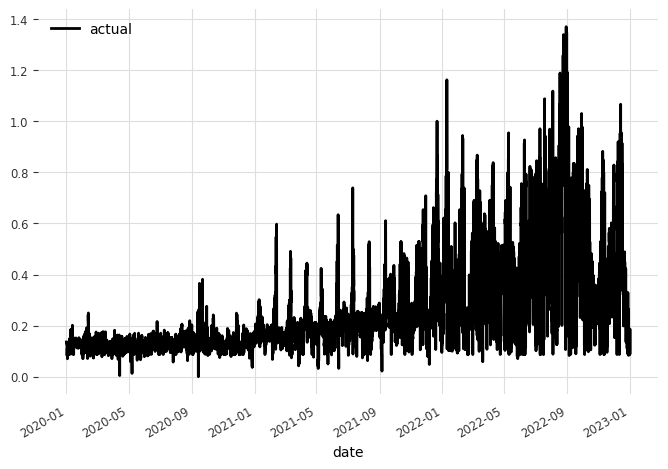

In [19]:
plt.figure(figsize=(8, 5))
series_transformed.plot(label="actual")
backtest_series.plot(label="backtest")
plt.legend()
plt.title("Backtest, starting Jan 2022, 12-months horizon")
r2 = r2_score(transformer.inverse_transform(series_transformed),
            transformer.inverse_transform(backtest_series))

In [ ]:
def eval_model(model):
    pred_series = model.predict(n=8750, future_covariates=covariates)
    plt.figure(figsize=(8, 5))
    series_transformed.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("RMSE: {:.2f}%".format(rmse(pred_series, test_transformed)))
    plt.legend()


eval_model(my_model)

In [ ]:
plt.figure(figsize=(8, 5))
series_transformed.plot(label="actual")
backtest_series.plot(label="backtest")
plt.legend()
plt.title("Backtest, starting Jan 2022, 12-months horizon")
print(
    "RMSE: {:.2f}%".format(
        rmse(
            transformer.inverse_transform(series_transformed),
            transformer.inverse_transform(backtest_series),
        )
    )
)

--------------------------------------------------ignore the below code------------------------------------------------------

In [ ]:
if __name__ == '__main__':
    model, accuracy = my_model()
    print(f"Model trained with accuracy: {accuracy}")
    mlflow.log_metric("accuracy", accuracy)
    mlflow.dart.log_model(my_model, "model", registered_model_name="ELPrice_RNN")
    mlflow.dart.save_model(my_model, "ELPrice_RNN")

In [ ]:
# Register the model in the MLflow registry
run_id_active = mlflow.active_run().info.run_id
model_uri = "runs:/" + run_id_active + "/test_0"
model_version = mlflow.register_model(model_uri, "ELPrice_RNN")

In [ ]:
# Log metrics
    y_pred = my_model.predict(train_transformed)
    mse = mean_squared_error(test_transformed, y_pred)
    rmse = math.sqrt(mse)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("rmse", rmse)   

In [93]:
my_model.fit(
    train_transformed,
    future_covariates=covariates,
    val_series=test_transformed,
    val_future_covariates=covariates,
    verbose=True,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.9 K 
4 | V             | Linear           | 21    
---------------------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=1, dropout=0, training_length=20, batch_size=16, n_epochs=10, optimizer_kwargs={'lr': 0.001}, model_name=ELPrice_RNN, log_tensorboard=True, random_state=42, input_chunk_length=72, force_reset=True, save_checkpoints=True)

In [ ]:
model_nbeats.fit(train, val_series=test, verbose=True)

In [ ]:
mlflow.pytorch.autolog()

In [14]:
from darts.metrics import rmse

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

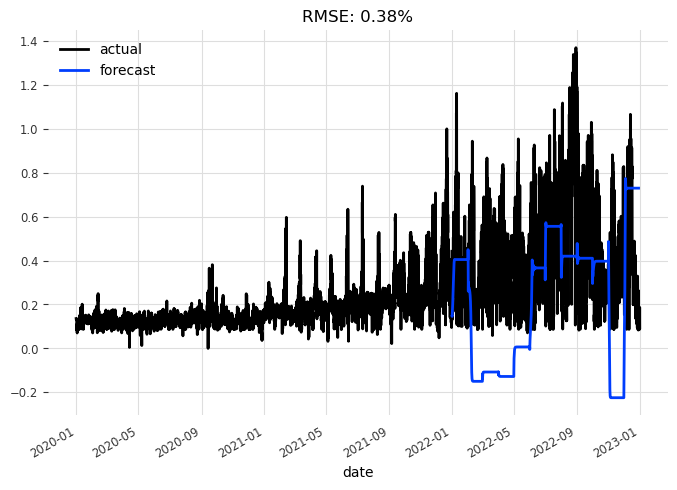

In [94]:

def eval_model(model):
    pred_series = model.predict(n=8700, future_covariates=covariates)
    plt.figure(figsize=(8, 5))
    series_transformed.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("RMSE: {:.2f}%".format(rmse(pred_series, test_transformed)))
    plt.legend()


eval_model(my_model)

In [ ]:
# Start an MLflow run
with mlflow.start_run(run_name="test_0", nested=True)
    # Log parameters
    model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=10,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name="nbeats_run",
)

# Log parameters
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=10,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name="nbeats_run",
)

In [ ]:

# Load data
data = pd.read_csv('df_clean.csv')
time_series = TimeSeries.from_dataframe(df, time_col='date', value_cols = 'Price', fill_missing_dates=True, freq=None)

# Split data and scaler
train, test = ts.split_after(pd.Timestamp("01.01.2022 01:00"))
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
test_transformed = transformer.transform(test)
series_transformed = transformer.transform(ts)

# Train a RNN model
model = RNNModel(input_chunk_length=72)
model.fit(train_transformed)

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_dim).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

def train_model(learning_rate=0.001):
    # Set the learning rate of the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train the model
    # ...
    
if __name__ == '__main__':
    model, accuracy = train_model(learning_rate=0.0001)
    print(f"Model trained with accuracy: {accuracy}")
    mlflow.log_metric("accuracy", accuracy)
    mlflow.sklearn.log_model(model, "model")
    mlflow.sklearn.log_model(model, "model", registered_model_name="rnn_model")
    mlflow.sklearn.save_model(model, "rnn_model")

    # Launch MLflow UI
    import os
    os.system("mlflow ui")

In [99]:
# Load data
data = pd.read_csv('df_clean.csv')
time_series = TimeSeries.from_dataframe(df, time_col='date', value_cols = 'Price', fill_missing_dates=True, freq=None)

# Split data and scaler
train, test = ts.split_after(pd.Timestamp("01.01.2022 01:00"))
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
test_transformed = transformer.transform(test)
series_transformed = transformer.transform(ts)

# Train a RNN model
model = RNNModel(input_chunk_length=72)
model.fit(train_transformed)

# Log metrics
y_pred = model.predict(train_transformed)
mse = mean_squared_error(test_transformed, y_pred)
rmse = math.sqrt(mse)
mlflow.log_metric("mse", mse)
    
if __name__ == '__main__':
    model, accuracy = train_model()
    print(f"Model trained with accuracy: {accuracy}")
    mlflow.log_metric("accuracy", accuracy)
    mlflow.dart.log_model(model, "model")
    mlflow.dart.log_model(model, "model", registered_model_name="rnn_model")
    mlflow.dart.save_model(model, "rnn_model")


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | V             | Linear           | 26    
---------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# backtest (later do that, if I find out theh best model!)
''''backtest_series = my_model.historical_forecasts(
    series_transformed,
    future_covariates=covariates,
    start=pd.Timestamp("01.01.2022 01:00"),
    forecast_horizon=12,
    retrain=False,
    verbose=True,
)

In [73]:
model = my_model

In [80]:
# connect mlflow
!pip install mlflow --q
import mlflow

In [81]:
mlflow.set_experiment('EL_Price_experiments')

# Start an MLflow run
mlflow.start_run(run_name="run_1", nested=True)

# Log parameters
mlflow.log_param("alpha", 0.5)

0.5

In [82]:
# Register the model in the MLflow registry
run_id_active = mlflow.active_run().info.run_id
model_uri = "runs:/" + run_id_active + "/model"
model_version = mlflow.register_model(model_uri, "MyModel")

Registered model 'MyModel' already exists. Creating a new version of this model...
2023/05/12 15:18:37 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: MyModel, version 2
Created version '2' of model 'MyModel'.


In [83]:
!mlflow experiments search -v all 

Experiment Id       Name                  Artifact Location                                                    
------------------  --------------------  ---------------------------------------------------------------------
0                   Default               file:///C:/Users/dicod/semester_projects_02/mlruns/0                 
110241433576543131  EL_Price_experiments  file:///C:/Users/dicod/semester_projects_02/mlruns/110241433576543131


In [84]:
import mlflow

# Set the name of the experiment
experiment_name = "EL_Price_experiments"

# Get the experiment ID for the experiment with the specified name
experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

# Search for runs associated with the experiment ID
runs = mlflow.search_runs(experiment_ids=experiment_id)

# # Print information about each run
# for run in runs:
#     print(f"Run {run.info.run_id} completed at {run.info.end_time} with status {run.info.status}")

In [85]:
runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,params.alpha,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.runName,tags.mlflow.parentRunId
0,62c6f46d7bf34358bccabcf5733cdc60,110241433576543131,RUNNING,file:///C:/Users/dicod/semester_projects_02/ml...,2023-05-12 13:18:20.388000+00:00,None,0.5,dicod,LOCAL,C:\Users\dicod\anaconda3\lib\site-packages\ipy...,run_1,6e0d24d6f1bf4567bfd09820c2c287ab
1,6e0d24d6f1bf4567bfd09820c2c287ab,110241433576543131,RUNNING,file:///C:/Users/dicod/semester_projects_02/ml...,2023-05-12 12:20:45.687000+00:00,None,0.5,dicod,LOCAL,C:\Users\dicod\anaconda3\lib\site-packages\ipy...,run_1,a535cabca57844349fce25846103e5df
2,a535cabca57844349fce25846103e5df,110241433576543131,RUNNING,file:///C:/Users/dicod/semester_projects_02/ml...,2023-05-12 12:09:08.740000+00:00,None,0.5,dicod,LOCAL,C:\Users\dicod\anaconda3\lib\site-packages\ipy...,run_1,05e2b6ae6f2041f2b31defb3ec7260a5
3,05e2b6ae6f2041f2b31defb3ec7260a5,110241433576543131,RUNNING,file:///C:/Users/dicod/semester_projects_02/ml...,2023-05-12 12:07:51.057000+00:00,None,0.5,dicod,LOCAL,C:\Users\dicod\anaconda3\lib\site-packages\ipy...,run_1,9c80ada3cde44b13b9d011309bb6cb37
4,9c80ada3cde44b13b9d011309bb6cb37,110241433576543131,RUNNING,file:///C:/Users/dicod/semester_projects_02/ml...,2023-05-12 12:06:37.353000+00:00,None,0.5,dicod,LOCAL,C:\Users\dicod\anaconda3\lib\site-packages\ipy...,run_1,None


In [37]:
runs['artifact_uri'][0]

'file:///C:/Users/dicod/semester_projects_02/mlruns/110241433576543131/6e0d24d6f1bf4567bfd09820c2c287ab/artifacts'

In [70]:
import mlflow.pyfunc

# Load the model from the registry
#"C:\Users\dicod\semester_projects_02\mlruns"
#semester_projects_02mlrunsmodels
# model_uri = '/content/model'

model_uri = "C:\\Users\\dicod\\semester_projects_02\\model"

loaded_model = mlflow.pyfunc.load_model(model_uri)

MlflowException: Could not find a registered artifact repository for: c:. Currently registered schemes are: ['', 'file', 's3', 'gs', 'wasbs', 'ftp', 'sftp', 'dbfs', 'hdfs', 'viewfs', 'runs', 'models', 'http', 'https', 'mlflow-artifacts']